# Visualization with Matplotlib

One of the most important things we can do once we have loaded our data is to discover insights from it via plotting.  In this module we'll look at different ways we can plot, as well as how matplotlib works with pandas to give us very powerful ways to gain insight into our data

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline

In [2]:
def get_data(token):
    res = requests.get(
        f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-12-01').timestamp()))
        }
    )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [3]:
tokens = ['BTC', 'ETH', 'SOL', 'AAVE', 'COMP']

In [4]:
dfs = [
    (lambda x: x.assign(chain=np.where(x.token.isin(['ETH', 'AAVE', 'COMP']), np.full(x.shape[0], 'ETH'), x.token)))(get_data(token)) 
    for token in tokens
]

df = pd.concat(get_data(token) for token in tokens)
df['chain'] = np.where(df.token.isin(['ETH', 'AAVE', 'COMP']), np.full(df.shape[0], 'ETH'), df.token)
df.set_index('ts', inplace=True)


In [41]:
dfs[3]

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-01 00:00:00,257.102,260.775,255.345,257.078,2730.299,7.039183e+05,AAVE,ETH
1,2021-12-01 01:00:00,257.149,266.249,255.270,264.816,5752.541,1.516148e+06,AAVE,ETH
2,2021-12-01 02:00:00,264.755,266.187,262.597,263.125,1559.330,4.124449e+05,AAVE,ETH
3,2021-12-01 03:00:00,263.184,266.409,261.700,266.257,1647.398,4.336408e+05,AAVE,ETH
4,2021-12-01 04:00:00,266.384,267.024,264.284,265.502,829.993,2.207369e+05,AAVE,ETH
...,...,...,...,...,...,...,...,...,...
399,2021-12-17 15:00:00,166.770,166.940,162.220,163.630,3791.733,6.223641e+05,AAVE,ETH
400,2021-12-17 16:00:00,163.490,167.470,161.980,167.080,5020.859,8.266941e+05,AAVE,ETH
401,2021-12-17 17:00:00,166.990,170.840,166.710,169.970,2540.624,4.285094e+05,AAVE,ETH
402,2021-12-17 18:00:00,169.720,169.760,167.100,167.610,891.418,1.499524e+05,AAVE,ETH


In [5]:
df_btc_close = dfs[0].set_index('ts')

In [6]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

df_comparison = reduce(
    df_merge, 
    [df[['ts', 'close']].rename(columns={'close': f'close_{token}'}) for df, token in zip(dfs, tokens)]
)

In [7]:
market_caps = pd.read_csv('data/market_caps.csv')

## Pandas plotting basics

By default, pandas already has many ways to be able to plot, for example we can load our data, then immediately call `.plot` to take a look at what we're dealing with

<AxesSubplot:xlabel='ts'>

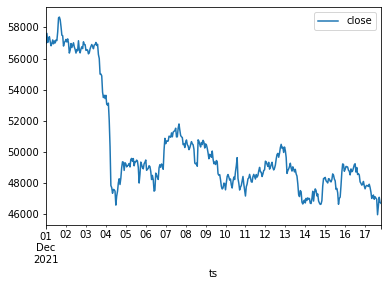

In [8]:
df_btc_close[['close']].plot()

pandas (and most of python) uses the matplotlib.pylot module to do plotting.  We can see this by replicating the chart above using matplotlib.  However you will see that by default since this is a single dimension time series, we don't have legend enabled and our dat formating is in YYYY-MM format

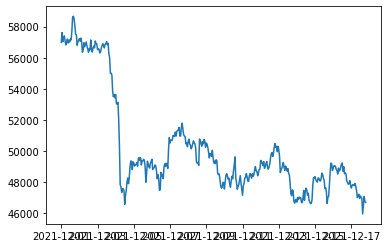

In [9]:
plt.plot(df_btc_close.index, df_btc_close.close)

we can also plot multiple columns together, such as:

<AxesSubplot:xlabel='ts'>

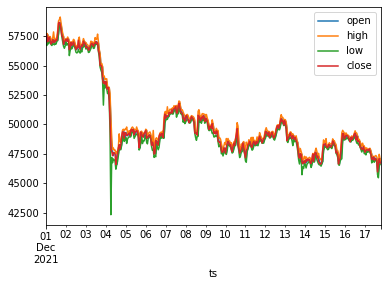

In [10]:
df_btc_close[['open', 'high', 'low', 'close']].plot()

or change the line type:

<AxesSubplot:xlabel='ts'>

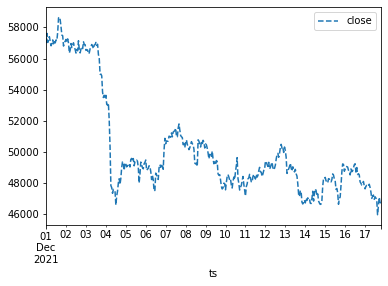

In [11]:
df_btc_close[['close']].plot(style='--')

You don't need to necessarily use the index, but instead can use any columns to plot against each other, e.g.:

<AxesSubplot:xlabel='close_BTC'>

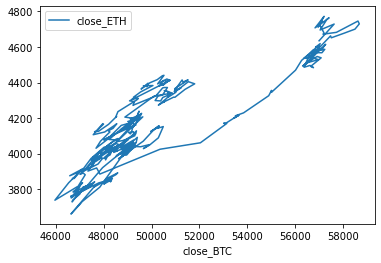

In [12]:
df_comparison.plot(x='close_BTC', y='close_ETH')

The above looks pretty terrible!  This is because we're now trying to plot the relationship between BTC and ETH, and using a line chart doesn't really make any sense.  Ideally, we want a scatter plot instead.

To do this in pandas, we can pass in the `kind=` argument to `.plot`, and specify the type of chart we'd like to generate, e.g.:

<AxesSubplot:xlabel='close_BTC', ylabel='close_ETH'>

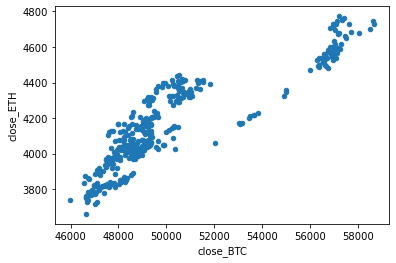

In [13]:
df_comparison.plot(x='close_BTC', y='close_ETH', kind='scatter')

Now we have something that looks like it makes a lot more sense.  This is very useful for 2-dimensional analysis, as we can now easily see the relationship between any two variables.

We can plot distributions just as easily, e.g. we can look at the distribution of prices by specifying a density chart below:

<AxesSubplot:ylabel='Density'>

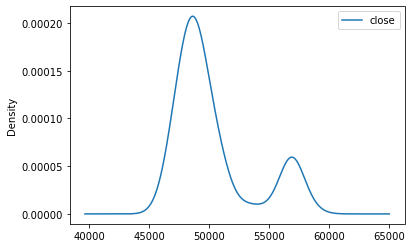

In [14]:
df_btc_close[['close']].plot(kind='density')

There's a lot of different charts we can specify - for example, if we want to easily want to see the top 10 crypto currency market caps against each other, we can use a Bar Chart.  The x-axis of the chart is the index, and the y axes are the rows you'd like to use:

<AxesSubplot:xlabel='Symbol'>

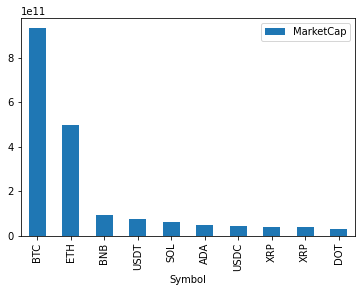

In [15]:
market_caps.head(n=10).set_index('Symbol')[['MarketCap']].plot(kind='bar')

Like with line charts, plotting multiple columns is pretty easy:

<AxesSubplot:xlabel='Symbol'>

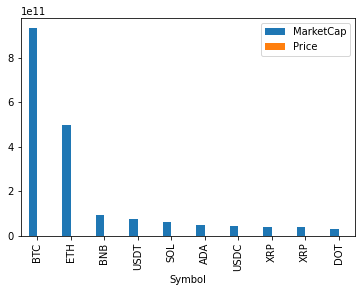

In [16]:
market_caps.head(n=10).set_index('Symbol')[['MarketCap', 'Price']].plot(kind='bar')

The above doesn't look great - because the size of Market Caps are so much larger than prices, we are not able to see the price charts at all.  However, we can easily add a secondary axis to the chart to help scale each series:

<AxesSubplot:xlabel='Symbol'>

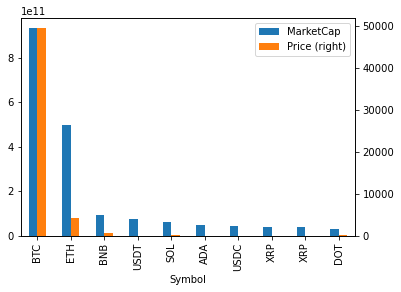

In [17]:
market_caps.head(n=10).set_index('Symbol')[['MarketCap', 'Price']].plot(kind='bar', secondary_y='Price')

Now price is plotted against the right y axis, while market cap is plotted against the left y axis, allowing us to make a much more sensible relative comparison.

There's a lot more types of plotting we can do with simple pandas plotting, e.g. boxplots, pie charts, bubble charts etc.  Please take a look at the documentation for more examples

## More advanced Pandas plotting

So now we can see how we can use pandas plotting to get some basic visualizations, we now want to see how we can very efficiently better understand the dependence relationships of our data.  Specifically we will look at how to find pair-wise relationships between our data easily, as well as time series properties.

Pandas again helps us with the `pandas.plotting` library, which allows us to do this out of the box

In [18]:
from pandas.plotting import scatter_matrix, lag_plot, autocorrelation_plot

In the above example, we saw that we could build a scatter plot for two of our features.  However what if our data set was more complex, and we had more features?  Pandas allows us to calculate _all_ pairwise scatters and feature densities using `scatter_matrix`.  

**note** - this function is very expensive, and I don't recommend putting too many features into it as it can take a long time to run

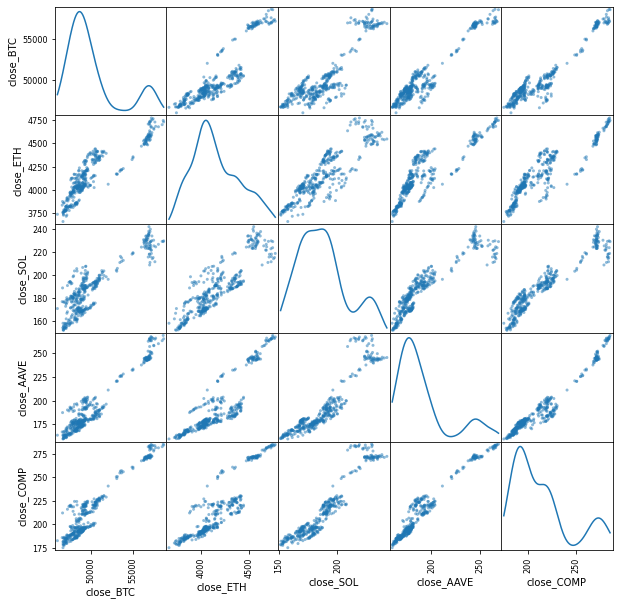

In [19]:
r = scatter_matrix(df_comparison, figsize=(10, 10), diagonal='kde')

we can now see how our features relate to each other!

if we wanted to understand a time series, we generally want to understand its autocorrelation and relationship to its lagged values.  We can do this using `lag_plot` and `autocorrelation` respectively, which does the hard work of taking the time diffs and calculating correlations for us before we plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

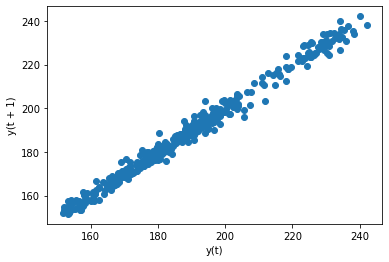

In [20]:
lag_plot(df_comparison.close_SOL)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

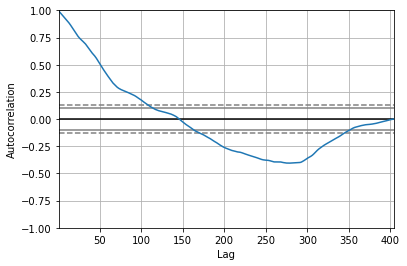

In [21]:
autocorrelation_plot(df_comparison.close_SOL)

There's also a lot more fucntions inside `pandas.plotting`, and they will be situationally useful, so go check it out!

## Matplotlib

The majority of charting in python is built on top of matplotlib.  It is extremely flexible and powerful, however usually requires a lot of boilerplate to get going.  In today's world we often will not use matplotlib directly but use a library on top of it, however understanding how matplotlib works is still very important.

There's two ways to use matlib - a procedural way and a OOP way.  The procedural way is fairly easy:
- create a figure
- start putting plots into the figure

i.e.:

Text(0.5, 1.0, 'SOL vs AAVE prices')

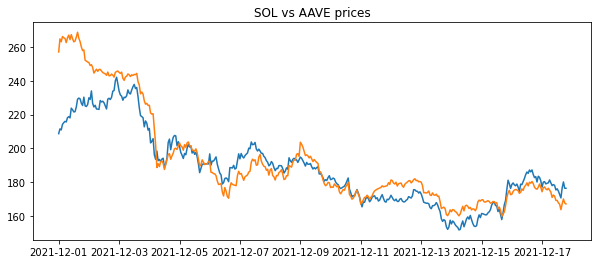

In [22]:
plt.figure(figsize=(10, 4))

plt.plot(df_comparison.ts, df_comparison.close_SOL)
plt.plot(df_comparison.ts, df_comparison.close_AAVE)
plt.title('SOL vs AAVE prices')

You can also get a little bit more complicated by using subplots.  In this way, you can select a subplot, push / update a plot, select another subplot to work on, and so forth, e.g.:


/Users/siddhantmadan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


Text(0, 0.5, 'priceUSD')

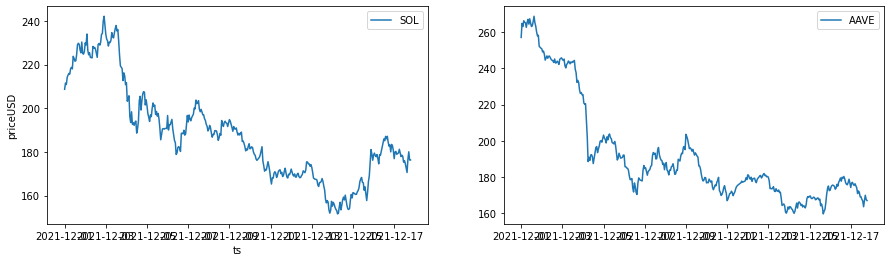

In [23]:
plt.figure(figsize=(15, 4))
plt.title('My Plots')

plt.subplot(1, 2, 1) #1 row, 2 columns, selecting first item
plt.plot(df_comparison.ts, df_comparison.close_SOL)
plt.legend(['SOL'])

plt.subplot(1, 2, 2) # switch to the second chart
plt.plot(df_comparison.ts, df_comparison.close_AAVE)
plt.legend(['AAVE'])

plt.subplot(1, 2, 1) # switch back to the first chart to add some labels
plt.xlabel('ts')
plt.ylabel('priceUSD')

**note** once the plot renders, it is flushed, and so further actions won't work, e.g. in the next cell we can try to update ylabel again, but it will create a completely new chart

Text(0, 0.5, 'price in USD')

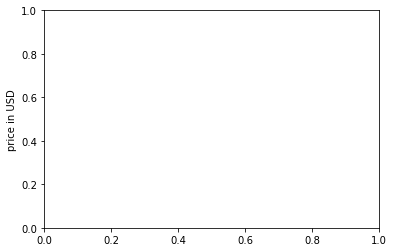

In [24]:
plt.ylabel('price in USD')

while this works okay, it can get pretty unweildy quickly.  In addition, if you want to pass this chart to other functions or classes, this becomes impossible to do.  Instead, we can use the OOP way to generate charts that allows us to act on the chart object and pass it around

we first call `plt.subplots` to create the objects we need for our plot.  In the example below, we will be creating 2 plots like above

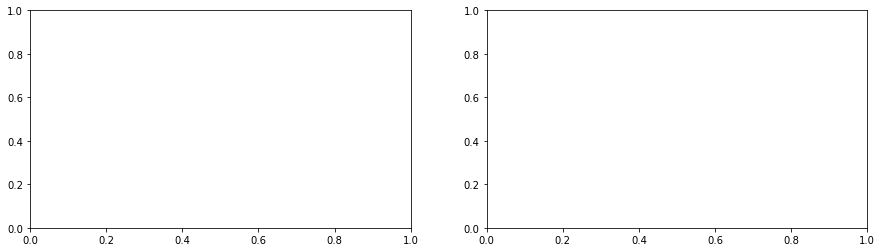

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

The axes object holds an array of subplots, which represent each plot.  Interestingly it's actually an `np.ndarray`, like our Series and DataFrames.

the fig object holds the full chart object, which means that you can add in chart-level things (e.g. titles)

In [26]:
axes

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

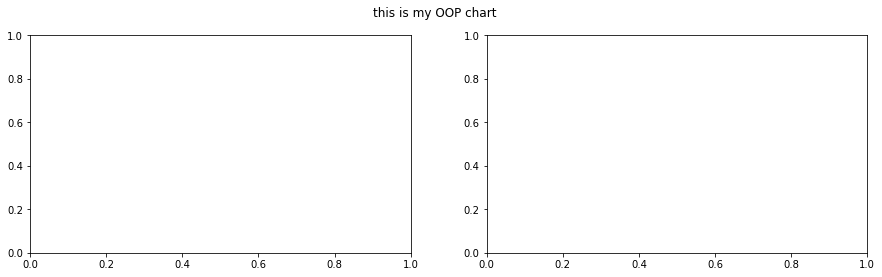

In [27]:
fig.suptitle('this is my OOP chart')
fig

Now we can add some data

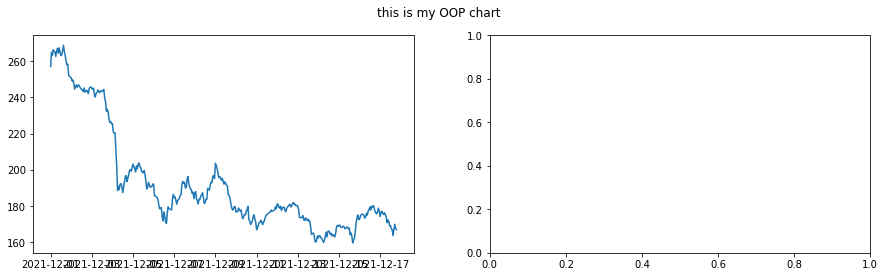

In [28]:
axes[0].plot(df_comparison.ts, df_comparison.close_AAVE)
fig

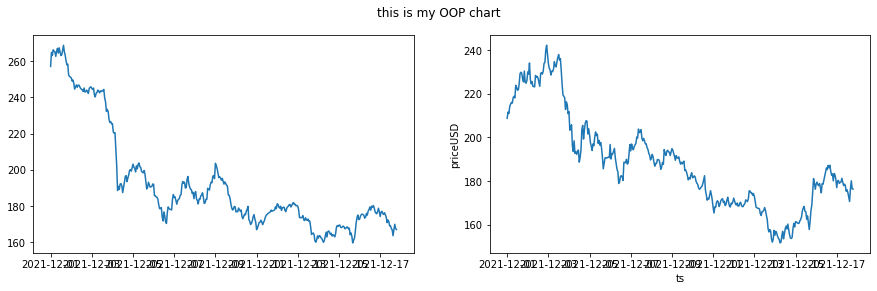

In [29]:
axes[1].plot(df_comparison.ts, df_comparison.close_SOL)
axes[1].set_xlabel('ts')
axes[1].set_ylabel('priceUSD')
fig

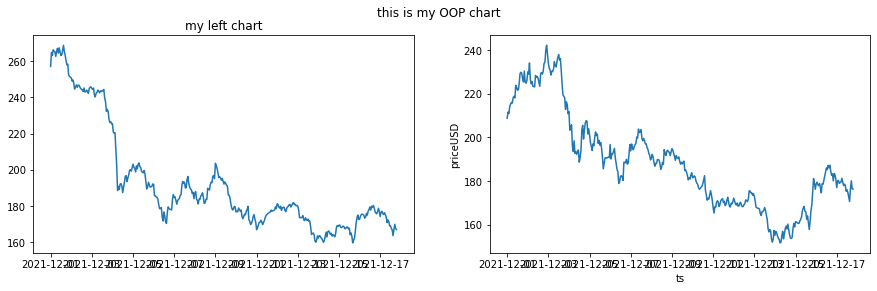

In [30]:
axes[0].set_title('my left chart')
fig

From this we can see that the fig can be rendered anywhere, and that we will not "flush" the object upon rendering.  We can also pass any individual axes object to a function to easily add data and change styling

Lastly, let's take a look at how pandas plotting works with matplotlib subplots.  Right now the way we've been using pandas plotting is similar to the procedural way, where we expect rendering to happen in place.  However, we can pass the axes that we want to render the plot to into the plot function, e.g.:

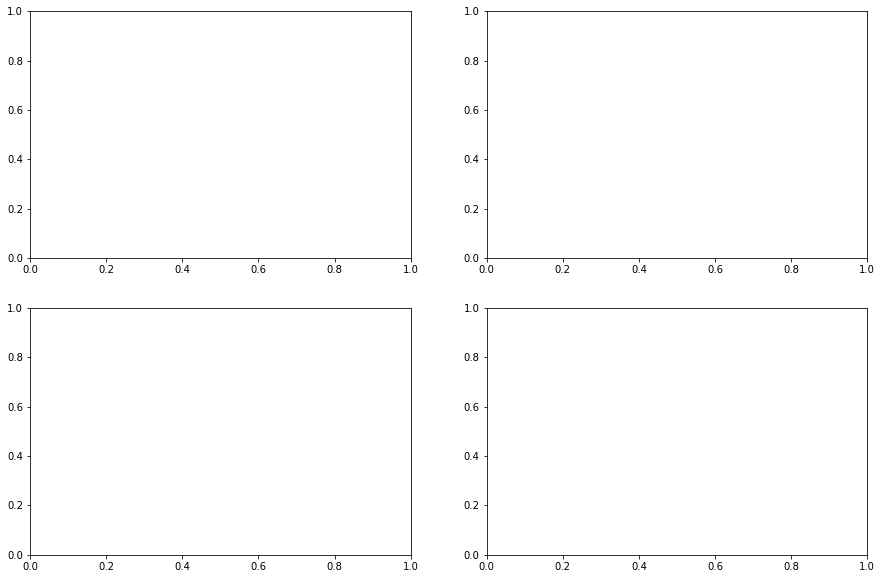

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

**note** this time, we've specified a 2d array, so we will need to access the axes via [row, col]

In [32]:
axes

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

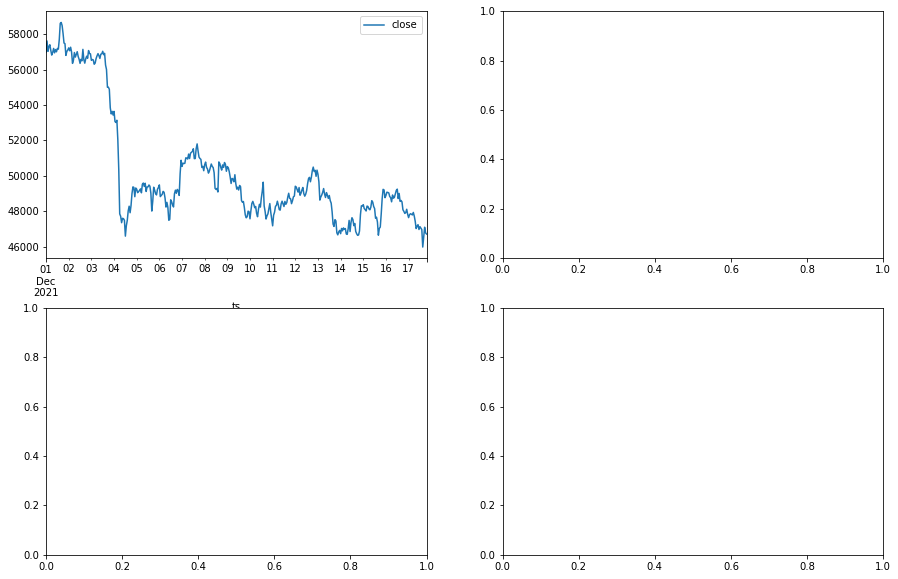

In [33]:
df_btc_close[['close']].plot(ax=axes[0, 0])
fig

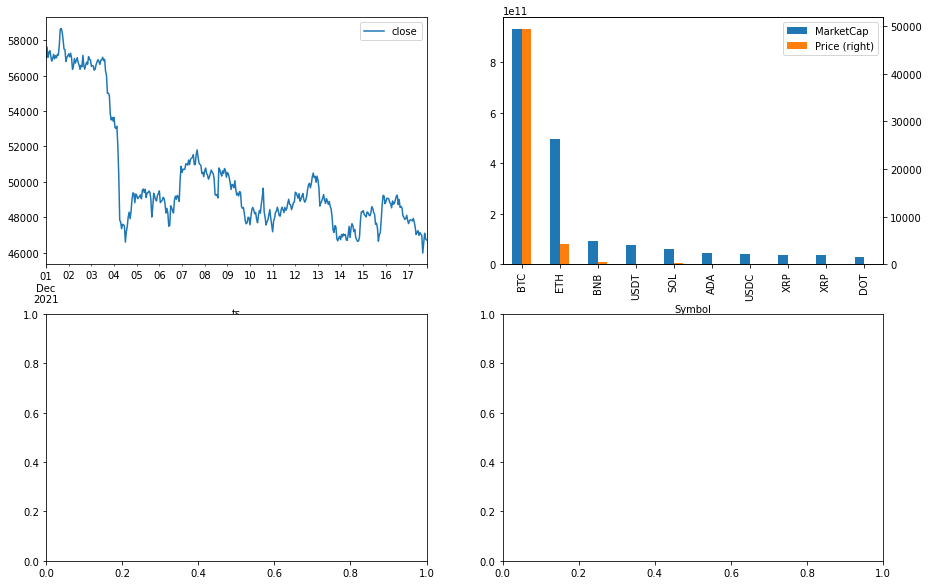

In [34]:
market_caps.head(n=10).set_index('Symbol')[['MarketCap', 'Price']].plot(kind='bar', secondary_y='Price', ax=axes[0, 1])
fig

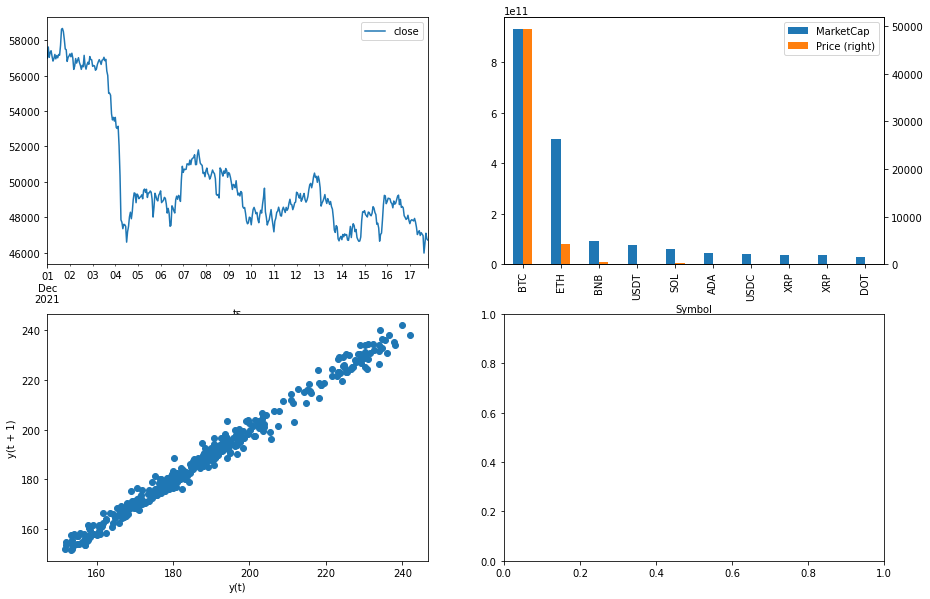

In [35]:
lag_plot(df_comparison.close_SOL, ax=axes[1, 0])
fig

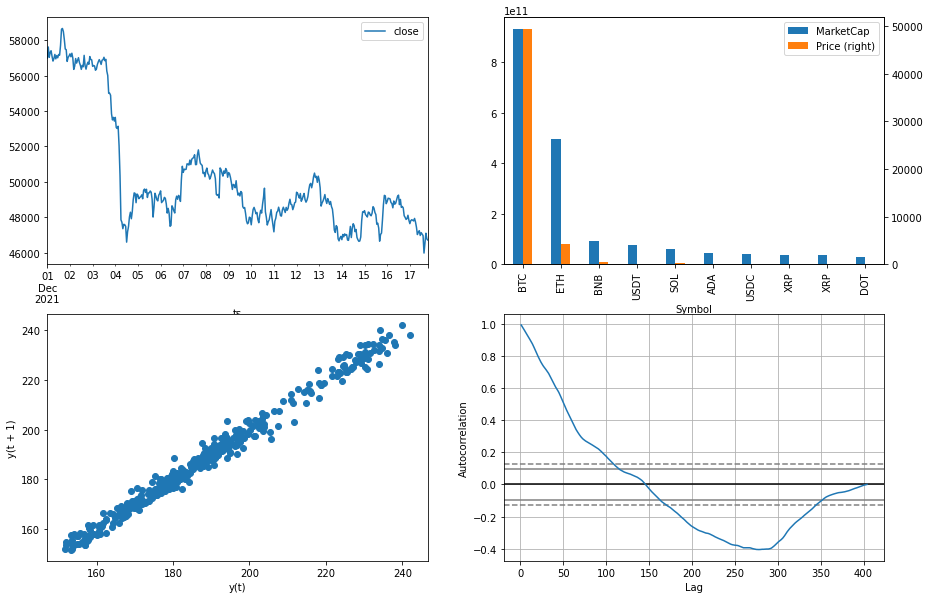

In [36]:
autocorrelation_plot(df_comparison.close_SOL, ax=axes[1, 1])
fig

With the above, you can encapsulate your chart logic into a library, return a chart and do whatever you'd like with it, e.g.:

In [37]:
def charter(crypto_data):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    
    crypto_data.close_BTC.plot(ax=axes[0, 0])
    crypto_data.plot(ax=axes[0, 1])
    lag_plot(crypto_data.close_SOL, ax=axes[1, 0])
    autocorrelation_plot(crypto_data.close_SOL, ax=axes[1, 1])
    
    return fig, axes


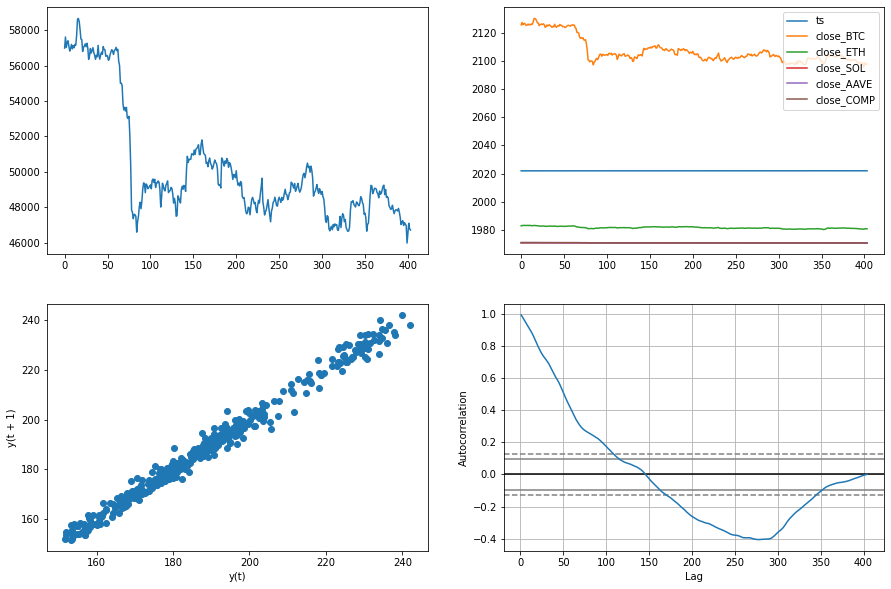

In [38]:
crypto_chart, _ = charter(df_comparison)
crypto_chart.savefig('crypto_chart.png')